In [15]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')



## 1. Data Preprocessing

### 1.1 Load Dataset and Initial Exploration

In [4]:
# Load the dataset
df = pd.read_csv('dataset.csv')

# Display the first 5 rows
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())



Dataset shape: (505, 12)

First 5 rows:
  Customer_ID   Name  Gender   Age    Country Subscription_Type   Join_Date  \
0    CUST1173  Frank     NaN  49.0     Canada             Basic  2018-06-23   
1    CUST1274  David    Male   NaN  Australia              Free  2018-10-02   
2    CUST1490  David  Female  18.0        USA             Basic  2019-05-06   
3    CUST1072    Bob   Other  21.0        USA              Free  2018-03-14   
4    CUST1305    Bob  Female  65.0        USA              Free  2018-11-02   

   Last_Login  Purchase_Amount Preferred_Payment_Method  Feedback_Score  \
0  2020-06-22            57.31                   PayPal             2.0   
1  2020-10-01           112.30            Bank Transfer             NaN   
2  2021-05-05           437.55           Cryptocurrency             3.0   
3  2020-03-13           432.04                   PayPal             5.0   
4  2020-11-01              NaN                   PayPal             1.0   

  Customer_Status  
0         Chur

In [16]:
df.info()

df['Customer_Status'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               505 non-null    object 
 1   Name                      505 non-null    object 
 2   Gender                    393 non-null    object 
 3   Age                       455 non-null    float64
 4   Country                   505 non-null    object 
 5   Subscription_Type         505 non-null    object 
 6   Join_Date                 505 non-null    object 
 7   Last_Login                505 non-null    object 
 8   Purchase_Amount           454 non-null    float64
 9   Preferred_Payment_Method  505 non-null    object 
 10  Feedback_Score            455 non-null    float64
 11  Customer_Status           505 non-null    object 
dtypes: float64(3), object(9)
memory usage: 47.5+ KB


Customer_Status
Active     255
Churned    164
At Risk     86
Name: count, dtype: int64

### 1.2 Check and Handle Missing Values

In [18]:
# Check for missing values
print("Missing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

print(f"\nTotal missing values: {df.isnull().sum().sum()}")
print(f"Percentage of missing values: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100:.2f}%")

# Create a copy for preprocessing
df_processed = df.copy()

# Handle missing values
# For numerical columns: use median
numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if df_processed[col].isnull().any():
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)
        print(f"Filled missing values in {col} with median: {median_val}")

# For categorical columns: use mode (most frequent value)
categorical_cols = df_processed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df_processed[col].isnull().any():
        mode_val = df_processed[col].mode()[0]
        df_processed[col].fillna(mode_val, inplace=True)
        print(f"Filled missing values in {col} with mode: {mode_val}")

df_processed.isnull().sum().sum()

Missing values per column:
Gender             112
Age                 50
Purchase_Amount     51
Feedback_Score      50
dtype: int64

Total missing values: 263
Percentage of missing values: 4.34%
Filled missing values in Age with median: 45.0
Filled missing values in Purchase_Amount with median: 256.46
Filled missing values in Feedback_Score with median: 3.0
Filled missing values in Gender with mode: Male


np.int64(0)

### 1.3 Remove Duplicates and Feature Encoding

In [24]:
# Remove duplicate rows
print(f"Dataset shape before removing duplicates: {df_processed.shape}")
df_processed = df_processed.drop_duplicates()
print(f"Dataset shape after removing duplicates: {df_processed.shape}")

# Drop unnecessary columns (ID and Name are not useful for prediction)
columns_to_drop = ['Customer_ID', 'Name', 'Join_Date', 'Last_Login']
df_processed = df_processed.drop(columns=[col for col in columns_to_drop if col in df_processed.columns])

print("Remaining columns:", df_processed.columns.tolist())
print("\nData types:")
print(df_processed.dtypes)

# Encode categorical features
# Create label encoders for categorical columns
label_encoders = {}
categorical_features = ['Gender', 'Country', 'Subscription_Type', 'Preferred_Payment_Method']

for col in categorical_features:
    if col in df_processed.columns:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])
        label_encoders[col] = le
        print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Encode target variable
target_le = LabelEncoder()
df_processed['Customer_Status'] = target_le.fit_transform(df_processed['Customer_Status'])
print(f"Target encoding: {dict(zip(target_le.classes_, target_le.transform(target_le.classes_)))}")

print("\nDataset after preprocessing:")
print(df_processed.head())

Dataset shape before removing duplicates: (505, 12)
Dataset shape after removing duplicates: (500, 12)
Remaining columns: ['Gender', 'Age', 'Country', 'Subscription_Type', 'Purchase_Amount', 'Preferred_Payment_Method', 'Feedback_Score', 'Customer_Status']

Data types:
Gender                       object
Age                         float64
Country                      object
Subscription_Type            object
Purchase_Amount             float64
Preferred_Payment_Method     object
Feedback_Score              float64
Customer_Status              object
dtype: object
Encoded Gender: {'Female': np.int64(0), 'Male': np.int64(1), 'Other': np.int64(2)}
Encoded Country: {'Australia': np.int64(0), 'Canada': np.int64(1), 'Germany': np.int64(2), 'India': np.int64(3), 'UK': np.int64(4), 'USA': np.int64(5)}
Encoded Subscription_Type: {'Basic': np.int64(0), 'Free': np.int64(1), 'Premium': np.int64(2)}
Encoded Preferred_Payment_Method: {'Bank Transfer': np.int64(0), 'Credit Card': np.int64(1), 'Crypt

### 1.4 Feature Scaling and Train-Test Split

In [25]:
# Separate features and target
X = df_processed.drop('Customer_Status', axis=1)
y = df_processed['Customer_Status']

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Features:", X.columns.tolist())

# Split the dataset into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train set target distribution:\n{pd.Series(y_train).value_counts()}")
print(f"Test set target distribution:\n{pd.Series(y_test).value_counts()}")

# Apply feature scaling (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling applied (StandardScaler)")
print("Original feature ranges (train set):")
for i, col in enumerate(X.columns):
    print(f"{col}: [{X_train.iloc[:, i].min():.2f}, {X_train.iloc[:, i].max():.2f}]")

print("\nScaled feature ranges (train set):")
for i, col in enumerate(X.columns):
    print(f"{col}: [{X_train_scaled[:, i].min():.2f}, {X_train_scaled[:, i].max():.2f}]")

Features shape: (500, 7)
Target shape: (500,)
Features: ['Gender', 'Age', 'Country', 'Subscription_Type', 'Purchase_Amount', 'Preferred_Payment_Method', 'Feedback_Score']

Train set: 400 samples
Test set: 100 samples
Train set target distribution:
Customer_Status
0    201
2    130
1     69
Name: count, dtype: int64
Test set target distribution:
Customer_Status
0    51
2    32
1    17
Name: count, dtype: int64

Feature scaling applied (StandardScaler)
Original feature ranges (train set):
Gender: [0.00, 2.00]
Age: [18.00, 69.00]
Country: [0.00, 5.00]
Subscription_Type: [0.00, 2.00]
Purchase_Amount: [22.22, 499.86]
Preferred_Payment_Method: [0.00, 3.00]
Feedback_Score: [1.00, 5.00]

Scaled feature ranges (train set):
Gender: [-1.47, 1.37]
Age: [-1.87, 1.71]
Country: [-1.43, 1.51]
Subscription_Type: [-1.25, 1.17]
Purchase_Amount: [-1.78, 1.85]
Preferred_Payment_Method: [-1.28, 1.40]
Feedback_Score: [-1.47, 1.55]


## 2. Model Training – Supervised Learning

### 2.1 Train Base Classifiers

In [53]:
# Initialize storage for base models and predictions
base_models = {}
base_predictions = {}


#### 2.1.1 Logistic Regression

In [54]:
# Train Logistic Regression
print("Training Logistic Regression...")

# Initialize the classifier
lr_clf = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
lr_clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_clf.predict(X_test_scaled)

# Store model and predictions
base_models['Logistic Regression'] = lr_clf
base_predictions['Logistic Regression'] = y_pred_lr

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr, average='weighted')
recall = recall_score(y_test, y_pred_lr, average='weighted')
f1 = f1_score(y_test, y_pred_lr, average='weighted')

print(f"Logistic Regression Results:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")


Training Logistic Regression...
Logistic Regression Results:
  Accuracy:  0.4900
  Precision: 0.3492
  Recall:    0.4900
  F1 Score:  0.3657


#### 2.1.2 Decision Tree

In [55]:
# Train Decision Tree
print("Training Decision Tree...")

# Initialize the classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Train the model
dt_clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_dt = dt_clf.predict(X_test_scaled)

# Store model and predictions
base_models['Decision Tree'] = dt_clf
base_predictions['Decision Tree'] = y_pred_dt

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_dt)
precision = precision_score(y_test, y_pred_dt, average='weighted')
recall = recall_score(y_test, y_pred_dt, average='weighted')
f1 = f1_score(y_test, y_pred_dt, average='weighted')

print(f"Decision Tree Results:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")


Training Decision Tree...
Decision Tree Results:
  Accuracy:  0.3800
  Precision: 0.3792
  Recall:    0.3800
  F1 Score:  0.3779


#### 2.1.3 Random Forest

In [56]:
# Train Random Forest
print("Training Random Forest...")

# Initialize the classifier
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)

# Train the model
rf_clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_clf.predict(X_test_scaled)

# Store model and predictions
base_models['Random Forest'] = rf_clf
base_predictions['Random Forest'] = y_pred_rf

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, average='weighted')
recall = recall_score(y_test, y_pred_rf, average='weighted')
f1 = f1_score(y_test, y_pred_rf, average='weighted')

print(f"Random Forest Results:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")


Training Random Forest...
Random Forest Results:
  Accuracy:  0.4700
  Precision: 0.4336
  Recall:    0.4700
  F1 Score:  0.4188


#### 2.1.4 Support Vector Machine (SVM)

In [57]:
# Train Support Vector Machine (SVM)
print("Training SVM...")

# Initialize the classifier
svm_clf = SVC(random_state=42, probability=True)

# Train the model
svm_clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svm = svm_clf.predict(X_test_scaled)

# Store model and predictions
base_models['SVM'] = svm_clf
base_predictions['SVM'] = y_pred_svm

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm, average='weighted')
recall = recall_score(y_test, y_pred_svm, average='weighted')
f1 = f1_score(y_test, y_pred_svm, average='weighted')

print(f"SVM Results:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")


Training SVM...
SVM Results:
  Accuracy:  0.5100
  Precision: 0.4203
  Recall:    0.5100
  F1 Score:  0.3756


#### 2.1.5 K-Nearest Neighbors (KNN)

In [58]:
# Train K-Nearest Neighbors (KNN)
print("Training KNN...")

# Initialize the classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_knn = knn_clf.predict(X_test_scaled)

# Store model and predictions
base_models['KNN'] = knn_clf
base_predictions['KNN'] = y_pred_knn

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn, average='weighted')
recall = recall_score(y_test, y_pred_knn, average='weighted')
f1 = f1_score(y_test, y_pred_knn, average='weighted')

print(f"KNN Results:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")


Training KNN...
KNN Results:
  Accuracy:  0.4200
  Precision: 0.3539
  Recall:    0.4200
  F1 Score:  0.3745


In [59]:
# Summary of Base Models Performance

print(" BASE MODELS TRAINING SUMMARY")


print(f" Total models trained: {len(base_models)}")
print(f" Models: {list(base_models.keys())}")

# Quick comparison of base models
print("\n Quick Performance Comparison:")
for model_name, predictions in base_predictions.items():
    accuracy = accuracy_score(y_test, predictions)
    print(f"  {model_name:20}: {accuracy:.4f}")




 BASE MODELS TRAINING SUMMARY
 Total models trained: 5
 Models: ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'KNN']

 Quick Performance Comparison:
  Logistic Regression : 0.4900
  Decision Tree       : 0.3800
  Random Forest       : 0.4700
  SVM                 : 0.5100
  KNN                 : 0.4200


## 3. Model Optimization

### 3.1 Hyperparameter Tuning

In [35]:
# Define parameter grids for hyperparameter tuning
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'],
        'penalty': ['l1', 'l2']
    },
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 5, 10]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}

# Perform hyperparameter tuning
tuned_models = {}
tuned_predictions = {}

print("Performing hyperparameter tuning...")


for name, clf in classifiers.items():
    print(f"\nTuning {name}...")
    
    # Skip penalty parameter for some solvers in Logistic Regression
    if name == 'Logistic Regression':
        # Use RandomizedSearchCV for faster tuning
        grid_search = RandomizedSearchCV(
            clf, param_grids[name], cv=5, scoring='accuracy', 
            n_iter=20, random_state=42, n_jobs=-1
        )
    else:
        # Use GridSearchCV for other models
        grid_search = GridSearchCV(
            clf, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1
        )
    
    # Fit the grid search
    grid_search.fit(X_train_scaled, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Make predictions
    y_pred_tuned = best_model.predict(X_test_scaled)
    
    # Store tuned model and predictions
    tuned_models[name] = best_model
    tuned_predictions[name] = y_pred_tuned
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_tuned)
    precision = precision_score(y_test, y_pred_tuned, average='weighted')
    recall = recall_score(y_test, y_pred_tuned, average='weighted')
    f1 = f1_score(y_test, y_pred_tuned, average='weighted')
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

print("\nHyperparameter tuning completed!")

Performing hyperparameter tuning...

Tuning Logistic Regression...
Best parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1}
Best CV score: 0.5075
Test Accuracy: 0.5000
Test Precision: 0.3671
Test Recall: 0.5000
Test F1 Score: 0.3713

Tuning Decision Tree...
Best parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1}
Best CV score: 0.5075
Test Accuracy: 0.5000
Test Precision: 0.3671
Test Recall: 0.5000
Test F1 Score: 0.3713

Tuning Decision Tree...
Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV score: 0.4700
Test Accuracy: 0.5200
Test Precision: 0.5222
Test Recall: 0.5200
Test F1 Score: 0.4236

Tuning Random Forest...
Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV score: 0.4700
Test Accuracy: 0.5200
Test Precision: 0.5222
Test Recall: 0.5200
Test F1 Score: 0.4236

Tuning Random Forest...
Best parameters: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50}
Best CV score: 0.5025
Tes

## 4. Ensemble Learning

### 4.1 Bagging, Boosting, and Stacking

In [36]:
# Initialize ensemble models
ensemble_models = {}
ensemble_predictions = {}

print("Training ensemble models...")


# 1. Bagging with Decision Tree
print("\n1. Training Bagging Classifier...")
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
bagging_clf.fit(X_train_scaled, y_train)
y_pred_bagging = bagging_clf.predict(X_test_scaled)

ensemble_models['Bagging'] = bagging_clf
ensemble_predictions['Bagging'] = y_pred_bagging

# Calculate metrics for Bagging
accuracy = accuracy_score(y_test, y_pred_bagging)
precision = precision_score(y_test, y_pred_bagging, average='weighted')
recall = recall_score(y_test, y_pred_bagging, average='weighted')
f1 = f1_score(y_test, y_pred_bagging, average='weighted')

print(f"Bagging - Accuracy: {accuracy:.4f}")
print(f"Bagging - Precision: {precision:.4f}")
print(f"Bagging - Recall: {recall:.4f}")
print(f"Bagging - F1 Score: {f1:.4f}")

# 2. Boosting with AdaBoost
print("\n2. Training AdaBoost Classifier...")
ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)
ada_clf.fit(X_train_scaled, y_train)
y_pred_ada = ada_clf.predict(X_test_scaled)

ensemble_models['AdaBoost'] = ada_clf
ensemble_predictions['AdaBoost'] = y_pred_ada

# Calculate metrics for AdaBoost
accuracy = accuracy_score(y_test, y_pred_ada)
precision = precision_score(y_test, y_pred_ada, average='weighted')
recall = recall_score(y_test, y_pred_ada, average='weighted')
f1 = f1_score(y_test, y_pred_ada, average='weighted')

print(f"AdaBoost - Accuracy: {accuracy:.4f}")
print(f"AdaBoost - Precision: {precision:.4f}")
print(f"AdaBoost - Recall: {recall:.4f}")
print(f"AdaBoost - F1 Score: {f1:.4f}")

# 3. Stacking with multiple base learners
print("\n3. Training Stacking Classifier...")

# Use the best tuned models as base learners
base_learners = [
    ('rf', tuned_models['Random Forest']),
    ('svm', tuned_models['SVM']),
    ('knn', tuned_models['KNN'])
]

# Use Logistic Regression as meta-learner
meta_learner = LogisticRegression(random_state=42, max_iter=1000)

stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train_scaled, y_train)
y_pred_stacking = stacking_clf.predict(X_test_scaled)

ensemble_models['Stacking'] = stacking_clf
ensemble_predictions['Stacking'] = y_pred_stacking

# Calculate metrics for Stacking
accuracy = accuracy_score(y_test, y_pred_stacking)
precision = precision_score(y_test, y_pred_stacking, average='weighted')
recall = recall_score(y_test, y_pred_stacking, average='weighted')
f1 = f1_score(y_test, y_pred_stacking, average='weighted')

print(f"Stacking - Accuracy: {accuracy:.4f}")
print(f"Stacking - Precision: {precision:.4f}")
print(f"Stacking - Recall: {recall:.4f}")
print(f"Stacking - F1 Score: {f1:.4f}")


Training ensemble models...

1. Training Bagging Classifier...
Bagging - Accuracy: 0.4400
Bagging - Precision: 0.4068
Bagging - Recall: 0.4400
Bagging - F1 Score: 0.3998

2. Training AdaBoost Classifier...
AdaBoost - Accuracy: 0.5200
AdaBoost - Precision: 0.5827
AdaBoost - Recall: 0.5200
AdaBoost - F1 Score: 0.3662

3. Training Stacking Classifier...
Stacking - Accuracy: 0.5100
Stacking - Precision: 0.2601
Stacking - Recall: 0.5100
Stacking - F1 Score: 0.3445
Stacking - Accuracy: 0.5100
Stacking - Precision: 0.2601
Stacking - Recall: 0.5100
Stacking - F1 Score: 0.3445


## 5. Model Evaluation

### 5.1 Comprehensive Model Comparison

In [37]:
# Combine all models and predictions
all_models = {**base_models, **tuned_models, **ensemble_models}
all_predictions = {**base_predictions, **tuned_predictions, **ensemble_predictions}

# Create evaluation results
evaluation_results = []

print("Evaluating all models...")


for model_name in all_models.keys():
    # Skip duplicates (base vs tuned models)
    if model_name in tuned_models:
        predictions = tuned_predictions[model_name]
        model_type = "Tuned"
    elif model_name in ensemble_models:
        predictions = ensemble_predictions[model_name]
        model_type = "Ensemble"
    else:
        predictions = base_predictions[model_name]
        model_type = "Base"
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, predictions)
    
    # Store results
    evaluation_results.append({
        'Model': model_name,
        'Type': model_type,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'Confusion_Matrix': cm
    })
    
    print(f"\n{model_name} ({model_type}):")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")

# Create results DataFrame
results_df = pd.DataFrame(evaluation_results)
results_df = results_df.drop('Confusion_Matrix', axis=1)  # Remove CM for display
results_df = results_df.round(4)

# Sort by accuracy (descending)
results_df = results_df.sort_values('Accuracy', ascending=False)


print("FINAL MODEL COMPARISON TABLE")

print(results_df.to_string(index=False))

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_accuracy = results_df.iloc[0]['Accuracy']
print(f"\nBest performing model: {best_model_name} (Accuracy: {best_accuracy:.4f})")

Evaluating all models...

Logistic Regression (Tuned):
  Accuracy:  0.5000
  Precision: 0.3671
  Recall:    0.5000
  F1 Score:  0.3713

Decision Tree (Tuned):
  Accuracy:  0.5200
  Precision: 0.5222
  Recall:    0.5200
  F1 Score:  0.4236

Random Forest (Tuned):
  Accuracy:  0.5000
  Precision: 0.3643
  Recall:    0.5000
  F1 Score:  0.3560

SVM (Tuned):
  Accuracy:  0.5100
  Precision: 0.2601
  Recall:    0.5100
  F1 Score:  0.3445

KNN (Tuned):
  Accuracy:  0.4600
  Precision: 0.3650
  Recall:    0.4600
  F1 Score:  0.3953

Bagging (Ensemble):
  Accuracy:  0.4400
  Precision: 0.4068
  Recall:    0.4400
  F1 Score:  0.3998

AdaBoost (Ensemble):
  Accuracy:  0.5200
  Precision: 0.5827
  Recall:    0.5200
  F1 Score:  0.3662

Stacking (Ensemble):
  Accuracy:  0.5100
  Precision: 0.2601
  Recall:    0.5100
  F1 Score:  0.3445
FINAL MODEL COMPARISON TABLE
              Model     Type  Accuracy  Precision  Recall  F1_Score
      Decision Tree    Tuned      0.52     0.5222    0.52    0.4236

### 5.2 Confusion Matrices

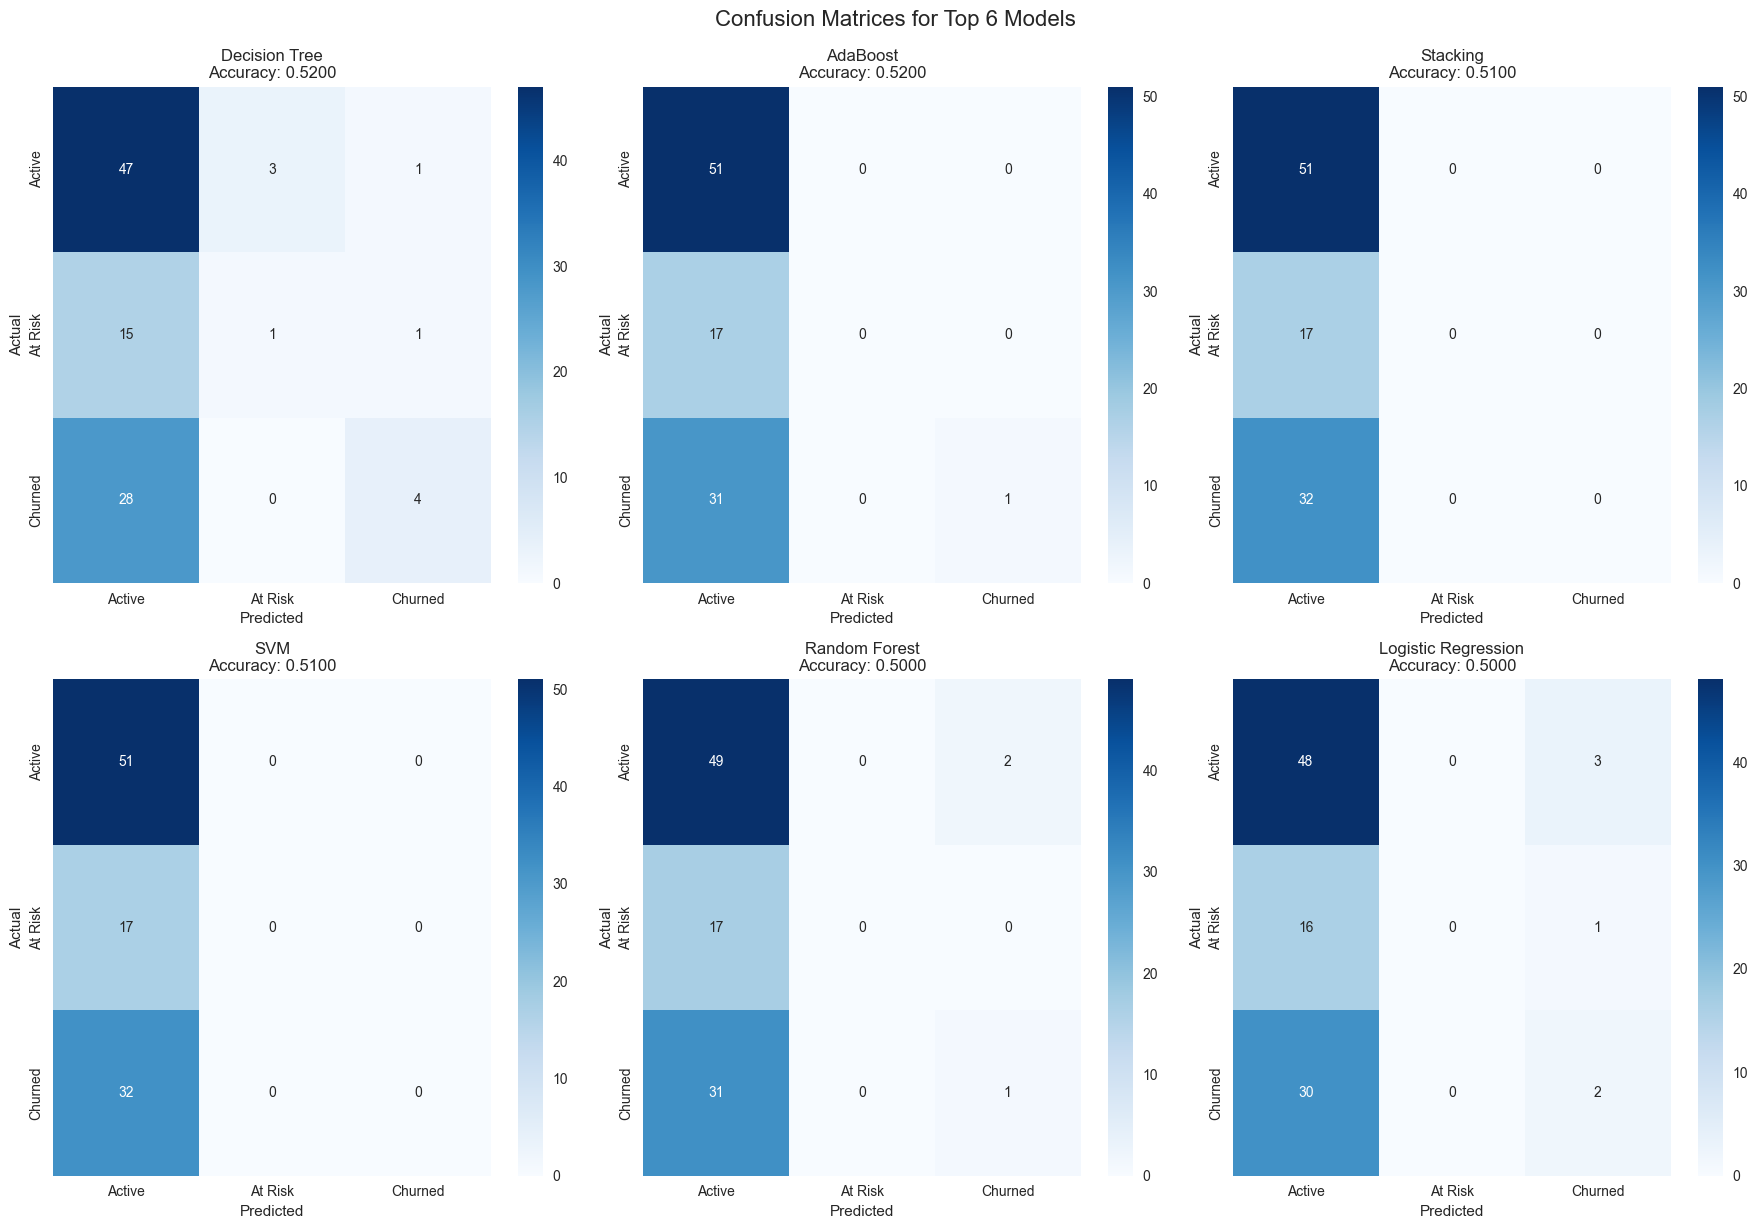


Detailed Classification Report for Best Model (Decision Tree):
              precision    recall  f1-score   support

      Active       0.52      0.92      0.67        51
     At Risk       0.25      0.06      0.10        17
     Churned       0.67      0.12      0.21        32

    accuracy                           0.52       100
   macro avg       0.48      0.37      0.32       100
weighted avg       0.52      0.52      0.42       100



In [12]:
# Plot confusion matrices for top 6 models
top_models = results_df.head(6)['Model'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# Get target class names
target_names = target_le.classes_

for i, model_name in enumerate(top_models):
    # Get predictions for this model
    if model_name in tuned_predictions:
        predictions = tuned_predictions[model_name]
    elif model_name in ensemble_predictions:
        predictions = ensemble_predictions[model_name]
    else:
        predictions = base_predictions[model_name]
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, predictions)
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names,
                ax=axes[i])
    axes[i].set_title(f'{model_name}\nAccuracy: {results_df[results_df["Model"] == model_name]["Accuracy"].iloc[0]:.4f}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.suptitle('Confusion Matrices for Top 6 Models', fontsize=16, y=1.02)
plt.show()

# Print detailed classification report for best model
print(f"\nDetailed Classification Report for Best Model ({best_model_name}):")
print("=" * 70)
if best_model_name in tuned_predictions:
    best_predictions = tuned_predictions[best_model_name]
elif best_model_name in ensemble_predictions:
    best_predictions = ensemble_predictions[best_model_name]
else:
    best_predictions = base_predictions[best_model_name]

print(classification_report(y_test, best_predictions, target_names=target_names))

## 6. Visualization

### 6.1 Model Performance Comparison

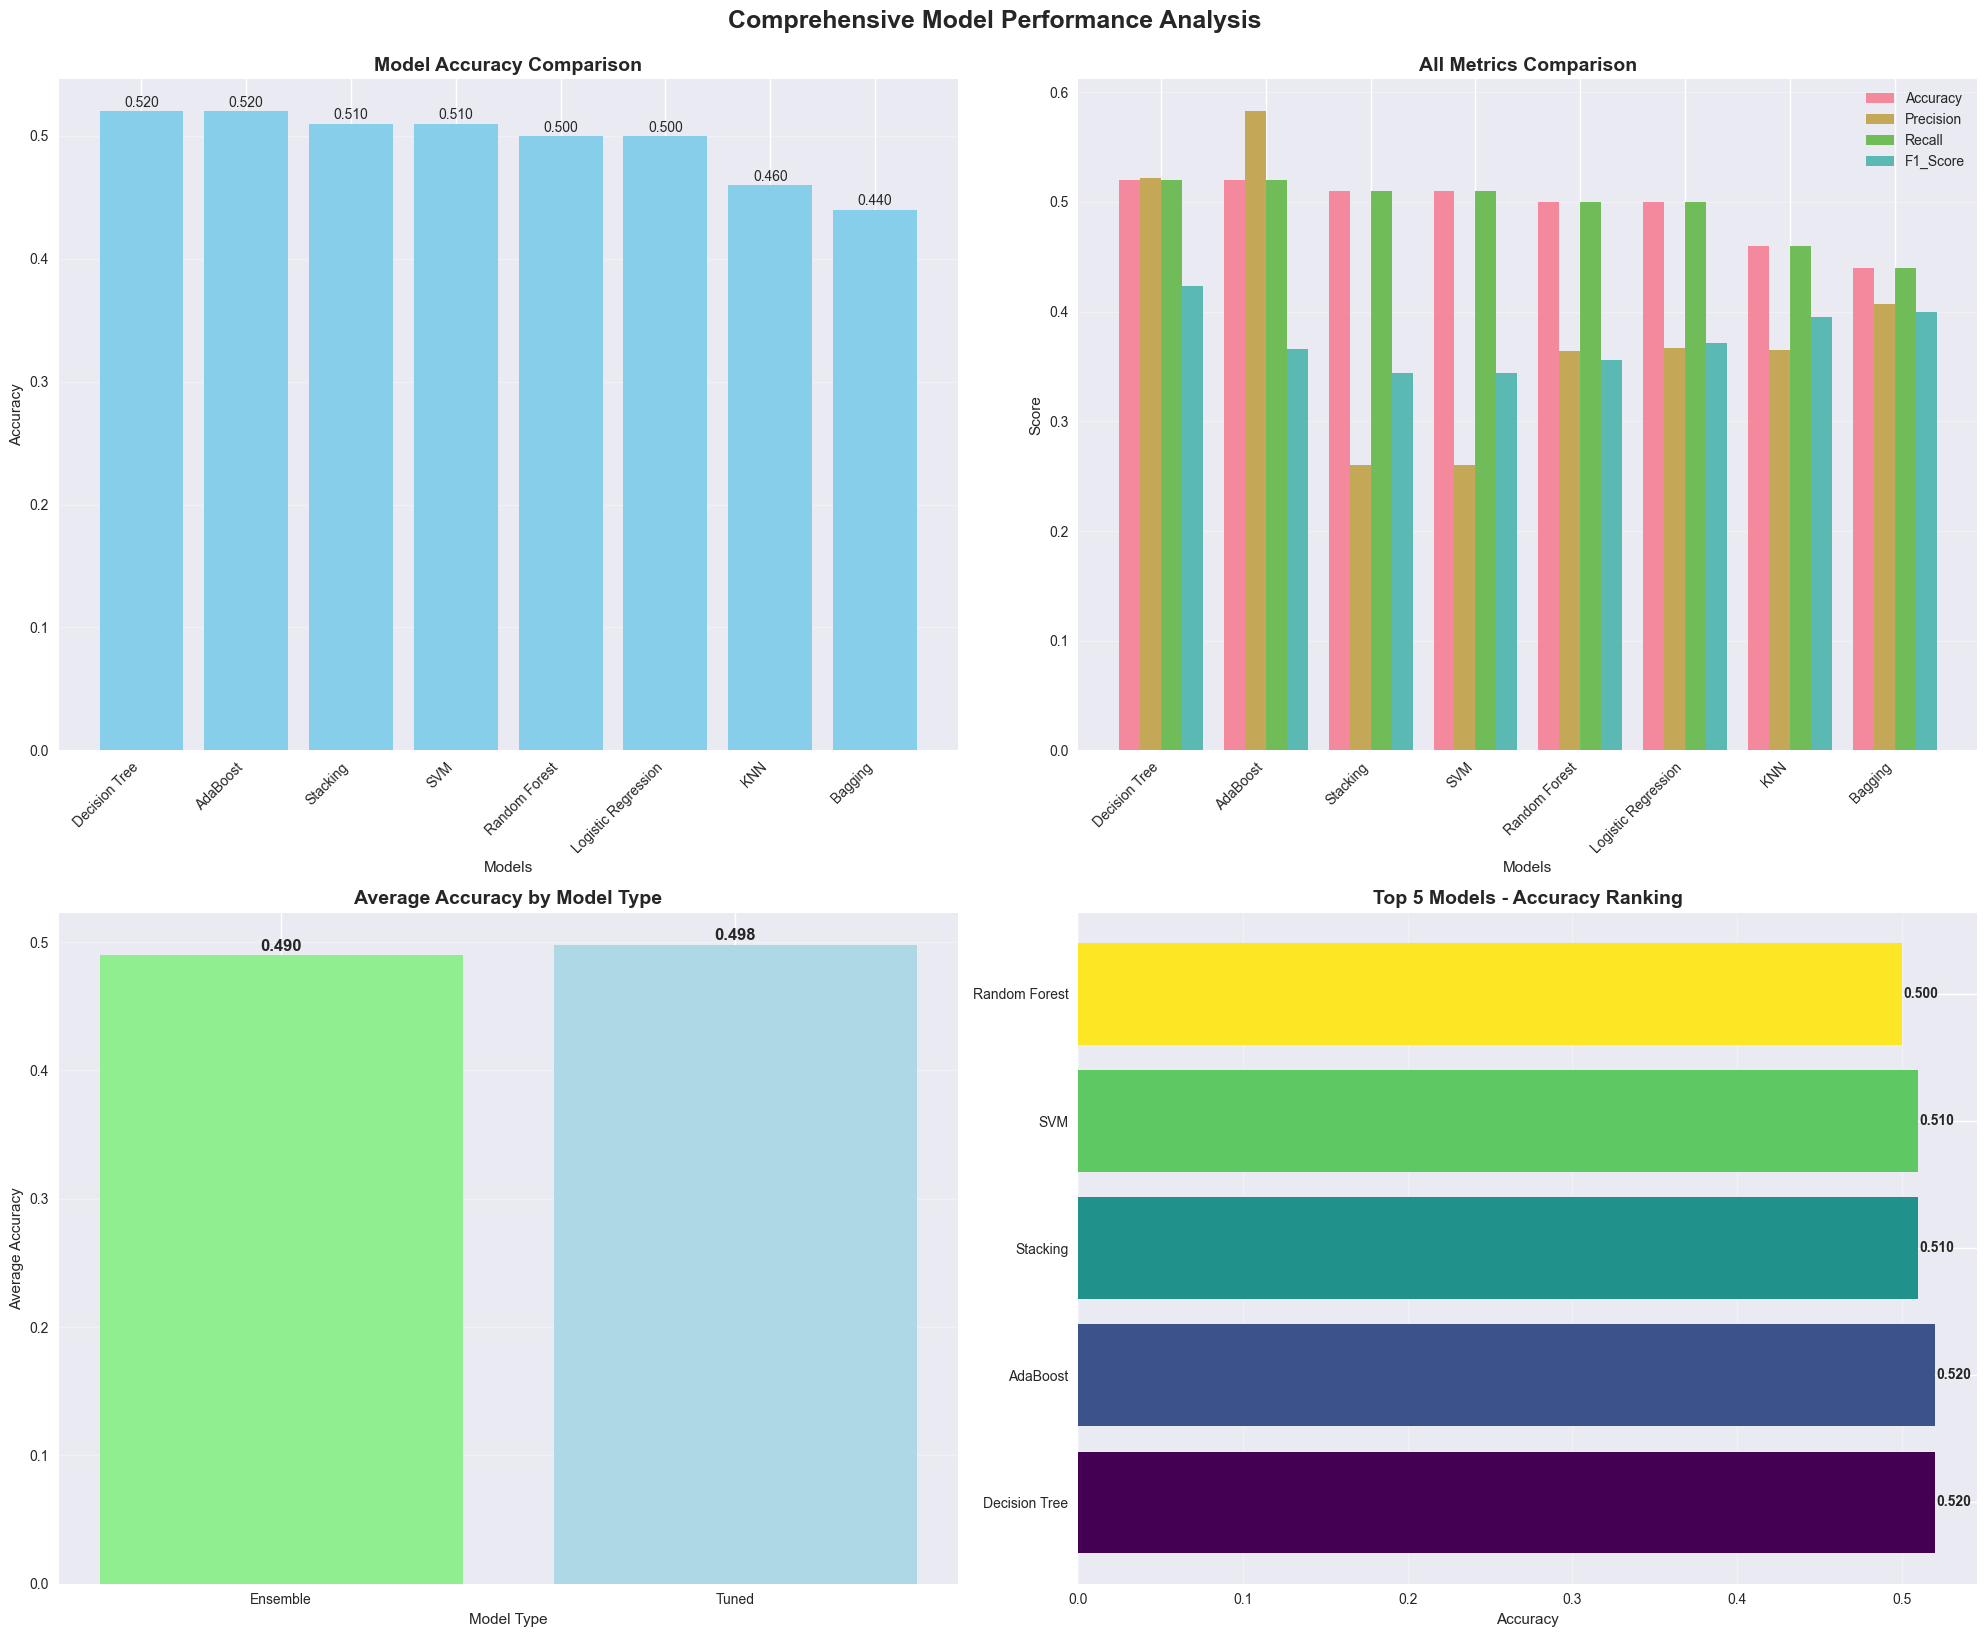

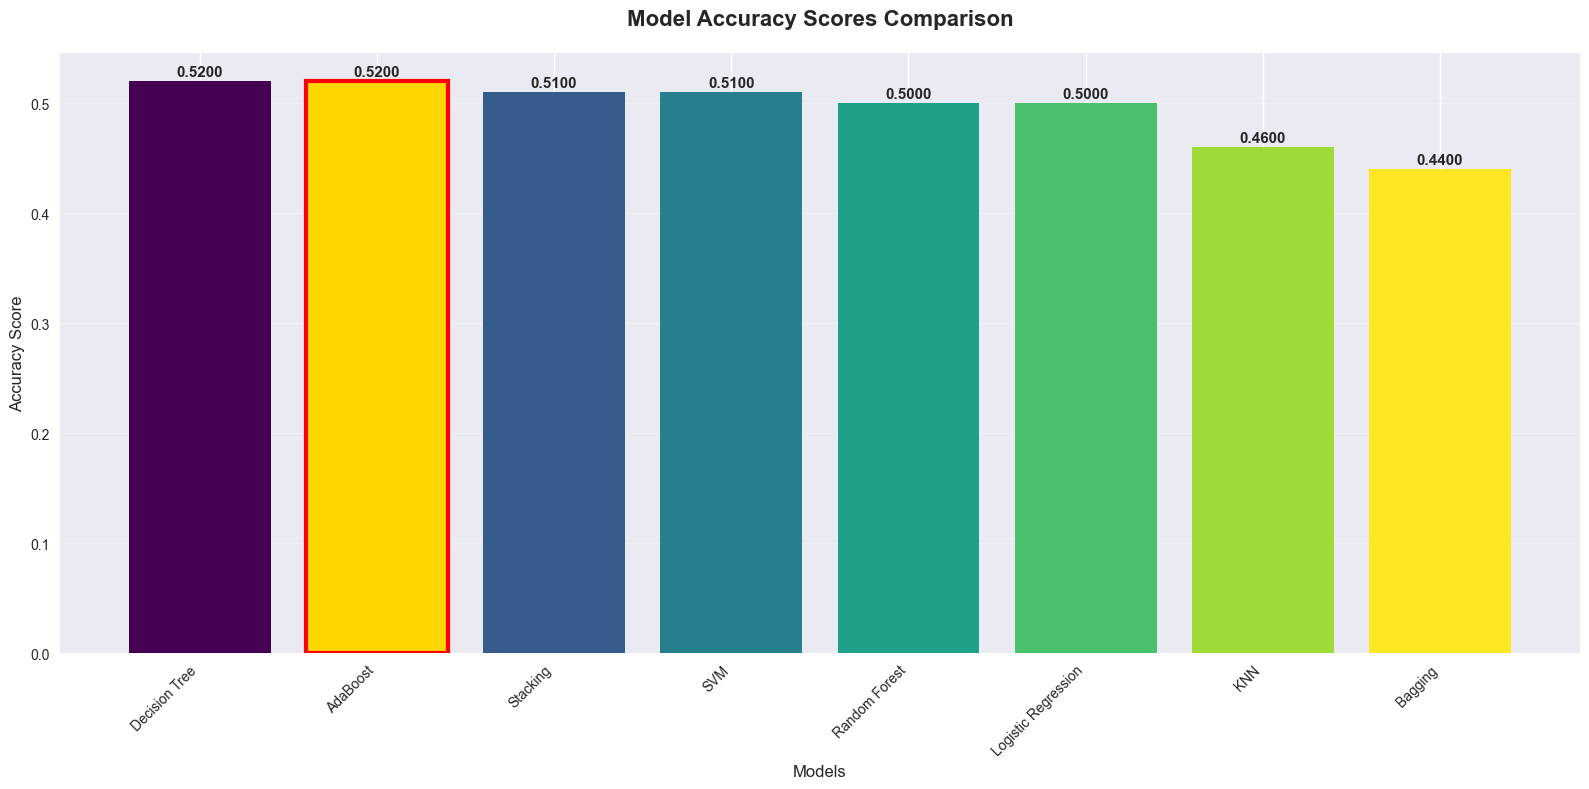


Visualization completed!


In [13]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Accuracy Comparison Bar Chart
ax1 = axes[0, 0]
colors = ['skyblue' if 'Ensemble' not in model else 'lightcoral' for model in results_df['Model']]
bars = ax1.bar(range(len(results_df)), results_df['Accuracy'], color=colors)
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(range(len(results_df)))
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# 2. All Metrics Comparison
ax2 = axes[0, 1]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics):
    ax2.bar(x + i*width, results_df[metric], width, label=metric, alpha=0.8)

ax2.set_title('All Metrics Comparison', fontsize=14, fontweight='bold')
ax2.set_xlabel('Models')
ax2.set_ylabel('Score')
ax2.set_xticks(x + width * 1.5)
ax2.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Model Type Performance
ax3 = axes[1, 0]
type_performance = results_df.groupby('Type')['Accuracy'].mean()
colors_type = ['lightgreen', 'lightblue', 'lightsalmon']
bars_type = ax3.bar(type_performance.index, type_performance.values, color=colors_type)
ax3.set_title('Average Accuracy by Model Type', fontsize=14, fontweight='bold')
ax3.set_xlabel('Model Type')
ax3.set_ylabel('Average Accuracy')
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars_type:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# 4. Top 5 Models Radar Chart (Alternative: Horizontal Bar Chart)
ax4 = axes[1, 1]
top_5_models = results_df.head(5)
y_pos = np.arange(len(top_5_models))

# Create horizontal bar chart
bars_h = ax4.barh(y_pos, top_5_models['Accuracy'], 
                  color=plt.cm.viridis(np.linspace(0, 1, len(top_5_models))))
ax4.set_title('Top 5 Models - Accuracy Ranking', fontsize=14, fontweight='bold')
ax4.set_xlabel('Accuracy')
ax4.set_yticks(y_pos)
ax4.set_yticklabels(top_5_models['Model'])
ax4.grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars_h):
    width = bar.get_width()
    ax4.text(width + 0.001, bar.get_y() + bar.get_height()/2.,
             f'{width:.3f}', ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.suptitle('Comprehensive Model Performance Analysis', fontsize=18, fontweight='bold', y=1.02)
plt.show()

# Additional standalone accuracy bar chart as requested
plt.figure(figsize=(16, 8))
colors_gradient = plt.cm.viridis(np.linspace(0, 1, len(results_df)))
bars = plt.bar(range(len(results_df)), results_df['Accuracy'], color=colors_gradient)

plt.title('Model Accuracy Scores Comparison', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.xticks(range(len(results_df)), results_df['Model'], rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{height:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Highlight best model
best_idx = results_df['Accuracy'].idxmax()
bars[best_idx].set_color('gold')
bars[best_idx].set_edgecolor('red')
bars[best_idx].set_linewidth(3)

plt.tight_layout()
plt.show()

print("\nVisualization completed!")

## 7. Project Summary and Conclusions

### Key Findings and Insights

In [41]:
# Project Summary
print("\n DATASET OVERVIEW:")
print(f"• Original dataset size: {df.shape}")
print(f"• Final processed dataset size: {df_processed.shape}")
print(f"• Target classes: {list(target_le.classes_)}")
print(f"• Features used: {list(X.columns)}")
print(" Train-test split (80%-20%)")
print(f"\n BEST MODEL PERFORMANCE:")
best_row = results_df.iloc[0]
print(f"• Best Model: {best_row['Model']} ({best_row['Type']})")
print(f"• Accuracy: {best_row['Accuracy']:.4f}")
print(f"• Precision: {best_row['Precision']:.4f}")
print(f"• Recall: {best_row['Recall']:.4f}")
print(f"• F1-Score: {best_row['F1_Score']:.4f}")

print(f"\n MODEL INSIGHTS:")
print(f"• Total models evaluated: {len(results_df)}")
print(f"• Best performing model type: {results_df.groupby('Type')['Accuracy'].mean().idxmax()}")
print(f"• Accuracy range: {results_df['Accuracy'].min():.4f} - {results_df['Accuracy'].max():.4f}")






 DATASET OVERVIEW:
• Original dataset size: (505, 12)
• Final processed dataset size: (500, 8)
• Target classes: ['Active', 'At Risk', 'Churned']
• Features used: ['Gender', 'Age', 'Country', 'Subscription_Type', 'Purchase_Amount', 'Preferred_Payment_Method', 'Feedback_Score']
 Train-test split (80%-20%)

 BEST MODEL PERFORMANCE:
• Best Model: Decision Tree (Tuned)
• Accuracy: 0.5200
• Precision: 0.5222
• Recall: 0.5200
• F1-Score: 0.4236

 MODEL INSIGHTS:
• Total models evaluated: 8
• Best performing model type: Tuned
• Accuracy range: 0.4400 - 0.5200
